# Analysis

In [1]:
import pickle

with open("CLIP_metrics.pkl", "rb") as f:
    data = pickle.load(f)

data

{'train_losses': [0.7031790614128113,
  0.7240029573440552,
  0.6968032121658325,
  0.7233434319496155,
  0.6949038505554199,
  0.6525879502296448,
  0.6830575466156006,
  0.6929193735122681,
  0.7268077731132507,
  0.6736433506011963,
  0.7129508852958679,
  0.6797904968261719,
  0.6729046702384949,
  0.7395368814468384,
  0.6748061180114746,
  0.6467138528823853,
  0.7073691487312317,
  0.649394690990448,
  0.7133249640464783,
  0.6773369908332825,
  0.6923914551734924,
  0.6577662825584412,
  0.712584376335144,
  0.7013491988182068,
  0.6384925246238708,
  0.644487738609314,
  0.6640892028808594,
  0.6164432764053345,
  0.6501248478889465,
  0.6610103845596313,
  0.651957094669342,
  0.711820662021637,
  0.694566011428833,
  0.5918440222740173,
  0.6079237461090088,
  0.590329110622406,
  0.6803178191184998,
  0.6451866030693054,
  0.5905216932296753,
  0.6545095443725586,
  0.6344521045684814,
  0.6154037714004517,
  0.6049520969390869,
  0.7135148644447327,
  0.6214517951011658,
 

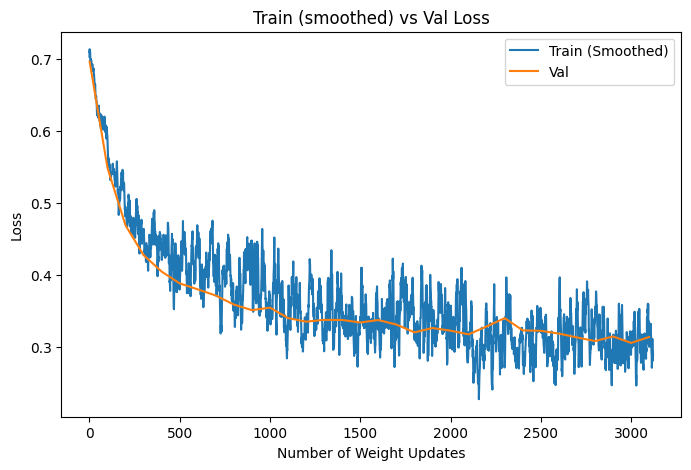

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

train_losses = np.array(data['train_losses'])
val_losses = np.array(data['val_losses'])

# Smooth only train
train_series  = pd.Series(train_losses)
train_smooth  = train_series.rolling(window=10, min_periods=1).mean()

# Val Steps 
val_every = 100
val_steps = [1] + [i * val_every for i in range(1, len(val_losses))]

plt.figure(figsize=(8,5))
plt.plot(train_smooth, label="Train (Smoothed)")
plt.plot(val_steps, val_losses, label="Val")
plt.xlabel("Number of Weight Updates")
plt.ylabel("Loss")
plt.legend()
plt.title("Train (smoothed) vs Val Loss")
plt.show()
